In [1]:
import os
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, balanced_accuracy_score, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.backends import cudnn
cudnn.deterministic = True
cudnn.benchmark = False

In [3]:
from option import get_option, parser
from trainer import Trainer
from utils import save_option
import data_loader
import models

In [4]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
#logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger(__name__)

import warnings
warnings.filterwarnings("ignore")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
def set_seed(seed=87):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(87)

In [6]:
from urlnet_utils import *

In [7]:
min_word_freq = 20
max_len_words = 200
max_len_chars = 200
max_len_subwords = 20
delimit_mode = 1
dev_pct = 0.01

In [8]:
urls, labels = read_data("../URLNet/train_10000.txt")

high_freq_words = None
if min_word_freq > 0:
    x1, word_reverse_dict = get_word_vocab(urls, max_len_words, min_word_freq) 
    high_freq_words = sorted(list(word_reverse_dict.values()))
    print("Number of words with freq >={}: {}".format(min_word_freq, len(high_freq_words)))

x, word_reverse_dict = get_word_vocab(urls, max_len_words)
word_x = get_words(x, word_reverse_dict, delimit_mode, urls)
ngramed_id_x, ngrams_dict, worded_id_x, words_dict = ngram_id_x(word_x, max_len_subwords, high_freq_words)
reverse_dict = {words_dict[i]:i for i in words_dict}
#chars_dict = ngrams_dict
#chared_id_x = char_id_x(urls, chars_dict, max_len_chars)
print("Overall Mal/Ben rate: {}/{}".format(np.sum(labels==1), np.sum(labels==0)))

########  shuffle & split  ######

shuffle_idx = np.random.permutation(np.arange(len(labels)))
train, test = prep_train_test(len(labels), dev_pct)
#y_train, y_test = to_categorical(labels[train], nb_classes=2), to_categorical(labels[test], nb_classes=2)
y_train, y_val = labels[train], labels[test]

#x_train_char = ngramed_id_x[train]
#x_val_char = ngramed_id_x[test]
x_train_word = pad_seq_in_word(worded_id_x[train], max_len_words)
x_val_word = pad_seq_in_word(worded_id_x[test], max_len_words)
#x_train_char_seq = pad_seq_in_word(chared_id_x[train], max_len_chars)
#x_val_char_seq = pad_seq_in_word(chared_id_x[test], max_len_chars)
print(x_train_word.shape, x_val_word.shape)
#print(x_train_char_seq.shape, x_val_char_seq.shape)

11/01/2019 05:12:00 - WARNING - tensorflow -   From /host/Proxy/learning-not-to-learn/urlnet_utils.py:113: VocabularyProcessor.__init__ (from tensorflow.contrib.learn.python.learn.preprocessing.text) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tensorflow/transform or tf.data.
11/01/2019 05:12:00 - WARNING - tensorflow -   From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/learn/python/learn/preprocessing/text.py:154: CategoricalVocabulary.__init__ (from tensorflow.contrib.learn.python.learn.preprocessing.categorical_vocabulary) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tensorflow/transform or tf.data.
11/01/2019 05:12:00 - WARNING - tensorflow -   From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/learn/python/learn/preprocessing/text.py:170: tokenizer (from tensorflow.contrib.learn.python.learn.preprocessing.text) is deprecated and will be removed in a future ver

Finished build vocabulary and mapping to x in 2.758134365081787
Size of word vocabulary: 1676
Number of words with freq >=20: 1676
Finished build vocabulary and mapping to x in 2.561713218688965
Size of word vocabulary: 63443
Processing #url 0
Size of ngram vocabulary: 131
Size of word vocabulary: 1733
Index of <UNKNOWN> word: 4
Overall Mal/Ben rate: 23613/23613
(46754, 200) (472, 200)


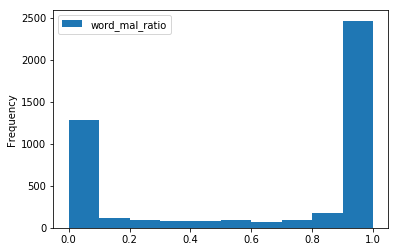

In [9]:
# from pandarallel import pandarallel
# pandarallel.initialize(nb_workers=1)

def build_word_ratio():
    df_tmp = pd.DataFrame({'token':word_x, "label":labels})
    word_mal_ratio = dict()

    for word in tqdm(words_dict):
        df_tmp['exist'] = df_tmp['token'].map(lambda x:word in x)
        cnt = len(df_tmp.query('exist == True & label == 0'))
        word_mal_ratio[word] = cnt / df_tmp.exist.sum()
    return word_mal_ratio

if not os.path.isfile("word_mal_ratio.pkl"):
    word_mal_ratio = build_word_ratio()
    with open("word_mal_ratio.pkl", "wb") as f:
        pickle.dump(word_mal_ratio, f)
else:
    with open("word_mal_ratio.pkl", "rb") as f:
        word_mal_ratio = pickle.load(f)
    if len(word_mal_ratio) < len(words_dict):
        word_mal_ratio = build_word_ratio()
        


tmp = [word_mal_ratio[i] for i in word_mal_ratio]
tmp = pd.DataFrame({'word_mal_ratio':tmp, 'word':[i for i in word_mal_ratio]})
tmp.plot(kind='hist')

In [10]:
tmp1 = words_dict
tmp2 = ngrams_dict

In [11]:
urls, labels = read_data("../URLNet/val_10000.txt")
x, word_reverse_dict = get_word_vocab(urls, max_len_words) 
word_x = get_words(x, word_reverse_dict, delimit_mode, urls) 
ngramed_id_x, worded_id_x = ngram_id_x_from_dict(word_x, max_len_subwords, ngrams_dict, words_dict) 
#chared_id_x = char_id_x(urls, chars_dict, max_len_chars)
print("Number of testing urls: {}".format(len(labels)))

y_test = labels
#x_test_char = ngramed_id_x
x_test_word = pad_seq_in_word(worded_id_x, max_len_words)
#x_test_char_seq = pad_seq_in_word(chared_id_x, max_len_chars)
print(x_test_word.shape)
#print(x_test_char_seq.shape, x_test_char_seq.shape)

Finished build vocabulary and mapping to x in 0.2624027729034424
Size of word vocabulary: 10884
Index of <UNKNOWN> word: 4
Processing url #0
Number of testing urls: 5248
(5248, 200)


In [12]:
assert tmp1 == words_dict
assert tmp2 == ngrams_dict

In [13]:
urls, labels = read_data("../taipei/out.csv")#"../URLNet/test_10000.txt"
### balance ###
n_subsample = min((labels==1).sum(), (labels==0).sum())
murl = urls[labels==0]
burl = urls[labels==1]
np.random.shuffle(murl)
np.random.shuffle(burl)
urls = np.concatenate([murl[:n_subsample], burl[:n_subsample]])
labels = np.array([0]*n_subsample+[1]*n_subsample)
print("balance", len(urls), len(labels))
###
x, word_reverse_dict = get_word_vocab(urls, max_len_words) 
word_x = get_words(x, word_reverse_dict, delimit_mode, urls) 
ngramed_id_x, worded_id_x = ngram_id_x_from_dict(word_x, max_len_subwords, ngrams_dict, words_dict)
#chared_id_x = char_id_x(urls, chars_dict, max_len_chars)
print("Number of testing urls: {}".format(len(labels)))

y_test2 = labels
#x_test_char2 = ngramed_id_x
x_test_word2 = pad_seq_in_word(worded_id_x, max_len_words)
#x_test_char_seq2 = pad_seq_in_word(chared_id_x, max_len_chars)
print(x_test_word2.shape)
#print(x_test_char_seq2.shape, x_test_char_seq2.shape)

balance 132894 132894
Finished build vocabulary and mapping to x in 6.818971157073975
Size of word vocabulary: 186707
Index of <UNKNOWN> word: 4
Processing url #0
Processing url #100000
Number of testing urls: 132894
(132894, 200)


In [14]:
assert tmp1 == words_dict
assert tmp2 == ngrams_dict

In [15]:
emb_dim = 32
l2_reg_lambda = 0.0
emb_mode = 2
filter_size = [3,4,5,6]
batch_size = 128
epochs = 5
lr = 1e-3

In [16]:
from torch.utils.data import Dataset, DataLoader
class mydata(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

idx = np.random.permutation(len(x_test_word2))[:30000]
train_dataset = mydata(x_train_word, y_train)
val_dataset = mydata(x_val_word, y_val)
test_dataset1 = mydata(x_test_word, y_test)
test_dataset2 = mydata(x_test_word2[idx], y_test2[idx])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)

In [17]:
def accuracy_thresh_sum(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, sigmoid:bool=True):
    y_pred = F.sigmoid(y_pred)
    return ((y_pred>thresh)==y_true.byte()).float().sum().item()

def accuracy_thresh_score(y_true, y_pred, thresh:float=0.5):
    return ((y_pred>0.5).astype(int) == y_true).mean()

In [18]:
def step(model, optimizer, loader, train=True, message=""):
    loss_total = 0
    all_logits = []
    all_labels = []
    
    model.train() if train else model.eval()
    mode = torch.enable_grad if train else torch.no_grad
    
    with mode():
        for (data, label) in tqdm(loader, desc=message):
            data, label = data.long().cuda(), label.long().cuda() # bce:float ce:long
            logits = model(data).squeeze()
            #loss = F.binary_cross_entropy_with_logits(logits, label, reduction="sum")
            loss = F.cross_entropy(F.softmax(logits, dim=1), label, reduction="sum")
            
            if train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            loss_total += loss.item()
            all_labels.append(label.detach().cpu().numpy())
            #F.sigmoid(logits).detach().cpu().numpy()
            tmp = F.softmax(logits, dim=1).detach().cpu().numpy()[:, 1]
            all_logits.append(tmp)
            
            
    loss_total /= len(loader)
    all_labels = np.hstack(all_labels)
    all_logits = np.hstack(all_logits)
    auc = roc_auc_score(all_labels, all_logits) if len(np.unique(all_labels)) > 1 else 0
    acc = accuracy_thresh_score(all_labels, all_logits)
    bacc = balanced_accuracy_score(all_labels, (all_logits>0.5).astype(int))
    (tn, fp, fn, tp) = confusion_matrix(all_labels, (all_logits>0.5).astype(int)).ravel()
    
    #logger.info(message)
    logger.info('Loss      : {}'.format(loss_total))
    logger.info('Accuracy  : {}'.format(acc))
    logger.info('balanceAcc: {}'.format(bacc))
    logger.info('AUC       : {}'.format(auc))
    logger.info('confusion : {}'.format((tn, fp, fn, tp)))
    
    
    return {'loss':loss_total, 'acc':acc, 'auc':auc}

In [19]:
# start straining
def train(history, epochs):
    for e in tqdm(range(epochs), desc="Epoch"):
        train_result =  step(model, optimizer, train_loader, train=True, message="Training :{}".format(e))
        valid_result = step(model, optimizer, val_loader, train=False, message="Validation :{}".format(e))
        test_result1 = step(model, optimizer, test_loader1, train=False, message="Test 1 :{}".format(e))
        test_result2 = step(model, optimizer, test_loader2, train=False, message="Test 2 :{}".format(e))

        history['train'].append(train_result)
        history['valid'].append(valid_result)
        history['test1'].append(test_result1)
        history['test2'].append(test_result2)
    return history
    
# history = {'train':[], 'valid':[], 'test1':[], 'test2':[]}
# history = train(history)

In [20]:
best = []
for i in range(1):
    set_seed(87+i)
    model = models.WordCNN(
            word_ngram_vocab_size = len(words_dict)+1,
            emb_size=emb_dim,
            word_seq_len=max_len_words,
            l2_reg_lambda=l2_reg_lambda,
            filter_size=256,
            dropout=0.2,
            kernel_sizes=filter_size).cuda()
    print('paramters count', sum(p.numel() for p in model.parameters()))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1)
    
    history = {'train':[], 'valid':[], 'test1':[], 'test2':[]}
    history = train(history, 10)
    best.append(max([i['auc'] for i in history['test2']]))
    
print(best)
print(np.mean(best))
best1 = np.mean(best)

paramters count 893250


11/01/2019 05:14:07 - INFO - __main__ -   Loss      : 47.18767652355257
11/01/2019 05:14:07 - INFO - __main__ -   Accuracy  : 0.9480900029943962
11/01/2019 05:14:07 - INFO - __main__ -   balanceAcc: 0.9480930396770745
11/01/2019 05:14:07 - INFO - __main__ -   AUC       : 0.982730431699499
11/01/2019 05:14:07 - INFO - __main__ -   confusion : (22245, 1115, 1312, 22082)


11/01/2019 05:14:07 - INFO - __main__ -   Loss      : 40.27152490615845
11/01/2019 05:14:07 - INFO - __main__ -   Accuracy  : 0.9745762711864406
11/01/2019 05:14:07 - INFO - __main__ -   balanceAcc: 0.9741368419152814
11/01/2019 05:14:07 - INFO - __main__ -   AUC       : 0.9895139603299222
11/01/2019 05:14:07 - INFO - __main__ -   confusion : (248, 5, 7, 212)


11/01/2019 05:14:08 - INFO - __main__ -   Loss      : 43.94659581998499
11/01/2019 05:14:08 - INFO - __main__ -   Accuracy  : 0.9723704268292683
11/01/2019 05:14:08 - INFO - __main__ -   balanceAcc: 0.9723704268292683
11/01/2019 05:14:08 - INFO - __main__ -   AUC       : 0.9927001807889649
11/01/2019 05:14:08 - INFO - __main__ -   confusion : (2615, 9, 136, 2488)


11/01/2019 05:14:12 - INFO - __main__ -   Loss      : 97.74875616520009
11/01/2019 05:14:12 - INFO - __main__ -   Accuracy  : 0.5378
11/01/2019 05:14:12 - INFO - __main__ -   balanceAcc: 0.5384999549621163
11/01/2019 05:14:12 - INFO - __main__ -   AUC       : 0.6480434258443213
11/01/2019 05:14:12 - INFO - __main__ -   confusion : (14902, 75, 13791, 1232)


11/01/2019 05:14:39 - INFO - __main__ -   Loss      : 43.6125289260364
11/01/2019 05:14:39 - INFO - __main__ -   Accuracy  : 0.9776917482996107
11/01/2019 05:14:39 - INFO - __main__ -   balanceAcc: 0.977693960721693
11/01/2019 05:14:39 - INFO - __main__ -   AUC       : 0.993407453731843
11/01/2019 05:14:39 - INFO - __main__ -   confusion : (22910, 450, 593, 22801)


11/01/2019 05:14:39 - INFO - __main__ -   Loss      : 40.5497727394104
11/01/2019 05:14:39 - INFO - __main__ -   Accuracy  : 0.9703389830508474
11/01/2019 05:14:39 - INFO - __main__ -   balanceAcc: 0.9701842727453209
11/01/2019 05:14:39 - INFO - __main__ -   AUC       : 0.9905066146876749
11/01/2019 05:14:39 - INFO - __main__ -   confusion : (246, 7, 7, 212)


11/01/2019 05:14:39 - INFO - __main__ -   Loss      : 44.2501363056462
11/01/2019 05:14:39 - INFO - __main__ -   Accuracy  : 0.9693216463414634
11/01/2019 05:14:39 - INFO - __main__ -   balanceAcc: 0.9693216463414634
11/01/2019 05:14:39 - INFO - __main__ -   AUC       : 0.9917577485964456
11/01/2019 05:14:39 - INFO - __main__ -   confusion : (2572, 52, 109, 2515)


11/01/2019 05:14:43 - INFO - __main__ -   Loss      : 94.6621630729513
11/01/2019 05:14:43 - INFO - __main__ -   Accuracy  : 0.5561666666666667
11/01/2019 05:14:43 - INFO - __main__ -   balanceAcc: 0.5568325736196953
11/01/2019 05:14:43 - INFO - __main__ -   AUC       : 0.6579650225044307
11/01/2019 05:14:43 - INFO - __main__ -   confusion : (14844, 133, 13182, 1841)


11/01/2019 05:15:10 - INFO - __main__ -   Loss      : 43.37221150841218
11/01/2019 05:15:10 - INFO - __main__ -   Accuracy  : 0.9805578132352312
11/01/2019 05:15:10 - INFO - __main__ -   balanceAcc: 0.9805599649570608
11/01/2019 05:15:10 - INFO - __main__ -   AUC       : 0.9943550435086974
11/01/2019 05:15:10 - INFO - __main__ -   confusion : (22975, 385, 524, 22870)


11/01/2019 05:15:10 - INFO - __main__ -   Loss      : 40.563055992126465
11/01/2019 05:15:10 - INFO - __main__ -   Accuracy  : 0.972457627118644
11/01/2019 05:15:10 - INFO - __main__ -   balanceAcc: 0.9724673777681521
11/01/2019 05:15:10 - INFO - __main__ -   AUC       : 0.9922031512263794
11/01/2019 05:15:10 - INFO - __main__ -   confusion : (246, 7, 6, 213)


11/01/2019 05:15:11 - INFO - __main__ -   Loss      : 44.03846294123952
11/01/2019 05:15:11 - INFO - __main__ -   Accuracy  : 0.977515243902439
11/01/2019 05:15:11 - INFO - __main__ -   balanceAcc: 0.977515243902439
11/01/2019 05:15:11 - INFO - __main__ -   AUC       : 0.9950727454825997
11/01/2019 05:15:11 - INFO - __main__ -   confusion : (2601, 23, 95, 2529)


11/01/2019 05:15:15 - INFO - __main__ -   Loss      : 92.49458517520986
11/01/2019 05:15:15 - INFO - __main__ -   Accuracy  : 0.5467333333333333
11/01/2019 05:15:15 - INFO - __main__ -   balanceAcc: 0.5474073447932684
11/01/2019 05:15:15 - INFO - __main__ -   AUC       : 0.6590755917821691
11/01/2019 05:15:15 - INFO - __main__ -   confusion : (14782, 195, 13403, 1620)


11/01/2019 05:15:43 - INFO - __main__ -   Loss      : 43.36332018127858
11/01/2019 05:15:43 - INFO - __main__ -   Accuracy  : 0.9815416862728322
11/01/2019 05:15:43 - INFO - __main__ -   balanceAcc: 0.9815441184866509
11/01/2019 05:15:43 - INFO - __main__ -   AUC       : 0.9946960499326017
11/01/2019 05:15:43 - INFO - __main__ -   confusion : (23007, 353, 510, 22884)


11/01/2019 05:15:44 - INFO - __main__ -   Loss      : 41.684486389160156
11/01/2019 05:15:44 - INFO - __main__ -   Accuracy  : 0.9703389830508474
11/01/2019 05:15:44 - INFO - __main__ -   balanceAcc: 0.9707979136210225
11/01/2019 05:15:44 - INFO - __main__ -   AUC       : 0.992816792102081
11/01/2019 05:15:44 - INFO - __main__ -   confusion : (244, 9, 5, 214)


11/01/2019 05:15:44 - INFO - __main__ -   Loss      : 45.235231259974036
11/01/2019 05:15:44 - INFO - __main__ -   Accuracy  : 0.9660823170731707
11/01/2019 05:15:44 - INFO - __main__ -   balanceAcc: 0.9660823170731707
11/01/2019 05:15:44 - INFO - __main__ -   AUC       : 0.9951373752137864
11/01/2019 05:15:44 - INFO - __main__ -   confusion : (2533, 91, 87, 2537)


11/01/2019 05:15:47 - INFO - __main__ -   Loss      : 88.60273677744765
11/01/2019 05:15:47 - INFO - __main__ -   Accuracy  : 0.5725666666666667
11/01/2019 05:15:47 - INFO - __main__ -   balanceAcc: 0.573173118704799
11/01/2019 05:15:47 - INFO - __main__ -   AUC       : 0.6573676299887834
11/01/2019 05:15:47 - INFO - __main__ -   confusion : (14508, 469, 12354, 2669)


11/01/2019 05:16:16 - INFO - __main__ -   Loss      : 43.5052117467578
11/01/2019 05:16:16 - INFO - __main__ -   Accuracy  : 0.9807075330453009
11/01/2019 05:16:16 - INFO - __main__ -   balanceAcc: 0.9807107580710895
11/01/2019 05:16:16 - INFO - __main__ -   AUC       : 0.9949326616867573
11/01/2019 05:16:16 - INFO - __main__ -   confusion : (23013, 347, 555, 22839)


11/01/2019 05:16:16 - INFO - __main__ -   Loss      : 40.47451305389404
11/01/2019 05:16:16 - INFO - __main__ -   Accuracy  : 0.9788135593220338
11/01/2019 05:16:16 - INFO - __main__ -   balanceAcc: 0.9783962315230927
11/01/2019 05:16:16 - INFO - __main__ -   AUC       : 0.9941704116808345
11/01/2019 05:16:16 - INFO - __main__ -   confusion : (249, 4, 6, 213)


11/01/2019 05:16:17 - INFO - __main__ -   Loss      : 44.30905570053473
11/01/2019 05:16:17 - INFO - __main__ -   Accuracy  : 0.9763719512195121
11/01/2019 05:16:17 - INFO - __main__ -   balanceAcc: 0.9763719512195121
11/01/2019 05:16:17 - INFO - __main__ -   AUC       : 0.9953515973564843
11/01/2019 05:16:17 - INFO - __main__ -   confusion : (2602, 22, 102, 2522)


11/01/2019 05:16:21 - INFO - __main__ -   Loss      : 90.40737406953852
11/01/2019 05:16:21 - INFO - __main__ -   Accuracy  : 0.5477333333333333
11/01/2019 05:16:21 - INFO - __main__ -   balanceAcc: 0.5484066315871472
11/01/2019 05:16:21 - INFO - __main__ -   AUC       : 0.673744237380896
11/01/2019 05:16:21 - INFO - __main__ -   confusion : (14790, 187, 13381, 1642)


11/01/2019 05:16:47 - INFO - __main__ -   Loss      : 43.35179129063757
11/01/2019 05:16:47 - INFO - __main__ -   Accuracy  : 0.9831672156393035
11/01/2019 05:16:47 - INFO - __main__ -   balanceAcc: 0.9831715774065707
11/01/2019 05:16:47 - INFO - __main__ -   AUC       : 0.9958864675669091
11/01/2019 05:16:47 - INFO - __main__ -   confusion : (23107, 253, 534, 22860)


11/01/2019 05:16:48 - INFO - __main__ -   Loss      : 40.30518579483032
11/01/2019 05:16:48 - INFO - __main__ -   Accuracy  : 0.9788135593220338
11/01/2019 05:16:48 - INFO - __main__ -   balanceAcc: 0.9783962315230927
11/01/2019 05:16:48 - INFO - __main__ -   AUC       : 0.993574819066183
11/01/2019 05:16:48 - INFO - __main__ -   confusion : (249, 4, 6, 213)


11/01/2019 05:16:48 - INFO - __main__ -   Loss      : 44.175755849698696
11/01/2019 05:16:48 - INFO - __main__ -   Accuracy  : 0.9767530487804879
11/01/2019 05:16:48 - INFO - __main__ -   balanceAcc: 0.9767530487804879
11/01/2019 05:16:48 - INFO - __main__ -   AUC       : 0.9957003074341909
11/01/2019 05:16:48 - INFO - __main__ -   confusion : (2607, 17, 105, 2519)


11/01/2019 05:16:52 - INFO - __main__ -   Loss      : 92.22519841295608
11/01/2019 05:16:52 - INFO - __main__ -   Accuracy  : 0.5437333333333333
11/01/2019 05:16:52 - INFO - __main__ -   balanceAcc: 0.5444186844332625
11/01/2019 05:16:52 - INFO - __main__ -   AUC       : 0.6686022875138227
11/01/2019 05:16:52 - INFO - __main__ -   confusion : (14848, 129, 13559, 1464)


11/01/2019 05:17:19 - INFO - __main__ -   Loss      : 43.34533347197569
11/01/2019 05:17:19 - INFO - __main__ -   Accuracy  : 0.9837660948795824
11/01/2019 05:17:19 - INFO - __main__ -   balanceAcc: 0.983771576850287
11/01/2019 05:17:19 - INFO - __main__ -   AUC       : 0.9961269696465317
11/01/2019 05:17:19 - INFO - __main__ -   confusion : (23157, 203, 556, 22838)


11/01/2019 05:17:19 - INFO - __main__ -   Loss      : 39.746604919433594
11/01/2019 05:17:19 - INFO - __main__ -   Accuracy  : 0.9830508474576272
11/01/2019 05:17:19 - INFO - __main__ -   balanceAcc: 0.9823488006930532
11/01/2019 05:17:19 - INFO - __main__ -   AUC       : 0.9946035699460356
11/01/2019 05:17:19 - INFO - __main__ -   confusion : (251, 2, 6, 213)


11/01/2019 05:17:20 - INFO - __main__ -   Loss      : 44.255798153760956
11/01/2019 05:17:20 - INFO - __main__ -   Accuracy  : 0.9744664634146342
11/01/2019 05:17:20 - INFO - __main__ -   balanceAcc: 0.9744664634146342
11/01/2019 05:17:20 - INFO - __main__ -   AUC       : 0.9957996484142624
11/01/2019 05:17:20 - INFO - __main__ -   confusion : (2614, 10, 124, 2500)


11/01/2019 05:17:24 - INFO - __main__ -   Loss      : 96.15057006186628
11/01/2019 05:17:24 - INFO - __main__ -   Accuracy  : 0.5387666666666666
11/01/2019 05:17:24 - INFO - __main__ -   balanceAcc: 0.5394666750127604
11/01/2019 05:17:24 - INFO - __main__ -   AUC       : 0.6640848946707079
11/01/2019 05:17:24 - INFO - __main__ -   confusion : (14917, 60, 13777, 1246)


11/01/2019 05:17:53 - INFO - __main__ -   Loss      : 43.27223599803904
11/01/2019 05:17:53 - INFO - __main__ -   Accuracy  : 0.9844077512084528
11/01/2019 05:17:53 - INFO - __main__ -   balanceAcc: 0.9844145711609698
11/01/2019 05:17:53 - INFO - __main__ -   AUC       : 0.9958636205967224
11/01/2019 05:17:53 - INFO - __main__ -   confusion : (23215, 145, 584, 22810)


11/01/2019 05:17:53 - INFO - __main__ -   Loss      : 39.53712511062622
11/01/2019 05:17:53 - INFO - __main__ -   Accuracy  : 0.989406779661017
11/01/2019 05:17:53 - INFO - __main__ -   balanceAcc: 0.9885844748858448
11/01/2019 05:17:53 - INFO - __main__ -   AUC       : 0.9924738751421299
11/01/2019 05:17:53 - INFO - __main__ -   confusion : (253, 0, 5, 214)


11/01/2019 05:17:53 - INFO - __main__ -   Loss      : 44.2716831114234
11/01/2019 05:17:53 - INFO - __main__ -   Accuracy  : 0.9748475609756098
11/01/2019 05:17:53 - INFO - __main__ -   balanceAcc: 0.9748475609756098
11/01/2019 05:17:53 - INFO - __main__ -   AUC       : 0.9938277880539858
11/01/2019 05:17:53 - INFO - __main__ -   confusion : (2617, 7, 125, 2499)


11/01/2019 05:17:56 - INFO - __main__ -   Loss      : 97.33305740356445
11/01/2019 05:17:56 - INFO - __main__ -   Accuracy  : 0.5384
11/01/2019 05:17:56 - INFO - __main__ -   balanceAcc: 0.5391005697075617
11/01/2019 05:17:56 - INFO - __main__ -   AUC       : 0.6399390645678451
11/01/2019 05:17:56 - INFO - __main__ -   confusion : (14917, 60, 13788, 1235)


11/01/2019 05:18:25 - INFO - __main__ -   Loss      : 43.18893372165701
11/01/2019 05:18:25 - INFO - __main__ -   Accuracy  : 0.9856696753218976
11/01/2019 05:18:25 - INFO - __main__ -   balanceAcc: 0.9856779735700876
11/01/2019 05:18:25 - INFO - __main__ -   AUC       : 0.9941414598828758
11/01/2019 05:18:25 - INFO - __main__ -   confusion : (23292, 68, 602, 22792)


11/01/2019 05:18:25 - INFO - __main__ -   Loss      : 39.43638896942139
11/01/2019 05:18:25 - INFO - __main__ -   Accuracy  : 0.9872881355932204
11/01/2019 05:18:25 - INFO - __main__ -   balanceAcc: 0.9863013698630136
11/01/2019 05:18:25 - INFO - __main__ -   AUC       : 0.9899110220730232
11/01/2019 05:18:25 - INFO - __main__ -   confusion : (253, 0, 6, 213)


11/01/2019 05:18:26 - INFO - __main__ -   Loss      : 44.288571520549496
11/01/2019 05:18:26 - INFO - __main__ -   Accuracy  : 0.9750381097560976
11/01/2019 05:18:26 - INFO - __main__ -   balanceAcc: 0.9750381097560976
11/01/2019 05:18:26 - INFO - __main__ -   AUC       : 0.9903174496207614
11/01/2019 05:18:26 - INFO - __main__ -   confusion : (2619, 5, 126, 2498)


11/01/2019 05:18:30 - INFO - __main__ -   Loss      : 98.2332740946019
11/01/2019 05:18:30 - INFO - __main__ -   Accuracy  : 0.5376666666666666
11/01/2019 05:18:30 - INFO - __main__ -   balanceAcc: 0.5383688702094771
11/01/2019 05:18:30 - INFO - __main__ -   AUC       : 0.5968332165545402
11/01/2019 05:18:30 - INFO - __main__ -   confusion : (14922, 55, 13815, 1208)


11/01/2019 05:18:56 - INFO - __main__ -   Loss      : 43.145413599379076
11/01/2019 05:18:56 - INFO - __main__ -   Accuracy  : 0.9859263378534457
11/01/2019 05:18:56 - INFO - __main__ -   balanceAcc: 0.9859351650727678
11/01/2019 05:18:56 - INFO - __main__ -   AUC       : 0.9917713111150734
11/01/2019 05:18:56 - INFO - __main__ -   confusion : (23315, 45, 613, 22781)


11/01/2019 05:18:56 - INFO - __main__ -   Loss      : 39.40569353103638
11/01/2019 05:18:56 - INFO - __main__ -   Accuracy  : 0.989406779661017
11/01/2019 05:18:56 - INFO - __main__ -   balanceAcc: 0.9885844748858448
11/01/2019 05:18:56 - INFO - __main__ -   AUC       : 0.9887920298879203
11/01/2019 05:18:56 - INFO - __main__ -   confusion : (253, 0, 5, 214)


11/01/2019 05:18:57 - INFO - __main__ -   Loss      : 44.25550777156179
11/01/2019 05:18:57 - INFO - __main__ -   Accuracy  : 0.9744664634146342
11/01/2019 05:18:57 - INFO - __main__ -   balanceAcc: 0.974466463414634
11/01/2019 05:18:57 - INFO - __main__ -   AUC       : 0.9870335330997174
11/01/2019 05:18:57 - INFO - __main__ -   confusion : (2619, 5, 129, 2495)


11/01/2019 05:19:01 - INFO - __main__ -   Loss      : 98.41492402097012
11/01/2019 05:19:01 - INFO - __main__ -   Accuracy  : 0.5373333333333333
11/01/2019 05:19:01 - INFO - __main__ -   balanceAcc: 0.5380352294250506
11/01/2019 05:19:01 - INFO - __main__ -   AUC       : 0.5461254973350582
11/01/2019 05:19:01 - INFO - __main__ -   confusion : (14914, 63, 13817, 1206)




[0.673744237380896]
0.673744237380896


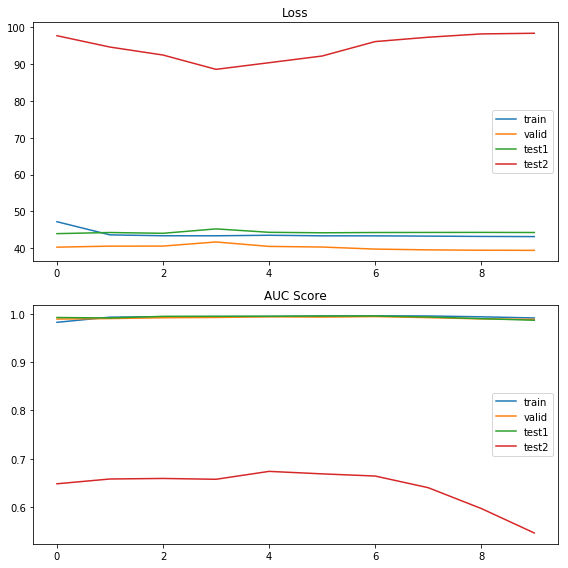

In [21]:
save = "baseline5"

train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
test1_loss = [l['loss'] for l in history['test1']]
test2_loss = [l['loss'] for l in history['test2']]

train_auc = [l['auc'] for l in history['train']]
valid_auc = [l['auc'] for l in history['valid']]
test1_auc = [l['auc'] for l in history['test1']]
test2_auc = [l['auc'] for l in history['test2']]

plt.figure(figsize=(8,8))

plt.subplot(211)
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.plot(test1_loss, label='test1')
plt.plot(test2_loss, label='test2')
plt.legend()


plt.subplot(212)
plt.title('AUC Score')
plt.plot(train_auc, label='train')
plt.plot(valid_auc, label='valid')
plt.plot(test1_auc, label='test1')
plt.plot(test2_auc, label='test2')
plt.legend()
plt.tight_layout()

# if save:
#     path = os.path.join("output", save+'.png')
#     plt.savefig(path)
plt.show()

# Adversarial training

In [22]:
UNKId = words_dict['<UNKNOWN>']
word_mal_ratio['<UNKNOWN>'] = 0.5
# data = list(map(lambda x:words_dict.get(x, UNKId), word_mal_ratio.keys()))
# label = list(map(lambda x:np.array([x, 1-x]), word_mal_ratio.values()))
data = list(words_dict.values())
label = list(map(lambda x:np.array([word_mal_ratio[x], 1-word_mal_ratio[x]]), words_dict.keys()))

emb_ratio_dataset = mydata(data, label)
emb_ratio_loader = DataLoader(emb_ratio_dataset, batch_size=batch_size, shuffle=True)

In [23]:
d, l = next(iter(emb_ratio_loader))
d.unsqueeze(1).shape

torch.Size([128, 1])

In [24]:
def soft_cross_entropy(inp, target, size_average=True):
    if size_average:
        return torch.mean(torch.sum(-target * F.log_softmax(inp), dim=1))
    else:
        return torch.sum(torch.sum(-target * F.log_softmax(inp), dim=1))

def NegativeEntropyLoss(x):
    b = F.softmax(x, dim=1) * F.log_softmax(x, dim=1)
    b = b.mean()
    return b

def special_loss(target):
    target = F.softmax(target, dim=1)
    return torch.mean(torch.sum(target*torch.log(target), 1))


def correlation_loss(target, label):
    vx = target - torch.mean(target)
    vy = label - torch.mean(label)
    corr = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
    corr = torch.clamp(corr, min=-1.0, max=1.0)
    return corr**2

In [25]:
def adv_step(model, optimizer, loader, train=True, message=""):
    loss_total = 0
    bias_loss_total = 0
    all_logits = []
    all_labels = []
    
    model.train() if train else model.eval()
    bias_model.train if train else bias_model.eval()
    mode = torch.enable_grad if train else torch.no_grad
    
    with mode():
        for (data, label) in tqdm(loader, desc=message):
            data, label = data.long().cuda(), label.long().cuda() # bce:float ce:long
            logits = model(data).squeeze()
            #loss = F.binary_cross_entropy_with_logits(logits, label, reduction="sum")
            loss = F.cross_entropy(F.softmax(logits, dim=1), label, reduction="sum")
            
            ##### uniform
#             _lambda = 0.01
#             out = bias_model(data)
#             loss_bias = NegativeEntropyLoss(out)
#             loss += loss_bias*_lambda
            
            if train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            bias_loss_total += emb_step(bias_model, bias_optimizer, train, 1)
                
            loss_total += loss.item()
            all_labels.append(label.detach().cpu().numpy())
            
            #F.sigmoid(logits).detach().cpu().numpy()
            tmp = F.softmax(logits, dim=1).detach().cpu().numpy()[:, 1]
            all_logits.append(tmp)
            

    
    loss_total /= len(loader)
    all_labels = np.hstack(all_labels)
    all_logits = np.hstack(all_logits)
    auc = roc_auc_score(all_labels, all_logits) if len(np.unique(all_labels)) > 1 else 0
    acc = accuracy_thresh_score(all_labels, all_logits)
    bacc = balanced_accuracy_score(all_labels, (all_logits>0.5).astype(int))
    (tn, fp, fn, tp) = confusion_matrix(all_labels, (all_logits>0.5).astype(int)).ravel()


    bias_loss_total = bias_loss_total/len(loader)

    logger.info('Loss       : {}'.format(loss_total))
    logger.info('Bias Loss  : {}'.format(bias_loss_total))
    logger.info('Accuracy   : {}'.format(acc))
    logger.info('balance Acc: {}'.format(bacc))
    logger.info('AUC        : {}'.format(auc))
    logger.info('confusion  : {}'.format((tn, fp, fn, tp)))
    
    return {'loss':loss_total, 'acc':acc, 'auc':auc, "bias":bias_loss_total}

In [26]:
def emb_step(model, optimizer, train=False, iters=1):
    loader = emb_ratio_loader
    loss_total = 0
    entropy_loss = 0
    
    model.train() if train else model.eval()
    mode = torch.enable_grad if train else torch.no_grad
    with mode():
        for _ in range(iters):
            for (data, label) in loader:
                data, label = data.long().unsqueeze(1).cuda(), label.float().cuda()
                logits = model(data)
                #label = (label>0.5)
                #loss = F.mse_loss(logits, label, reduction="sum") * 0.1
                #loss = soft_cross_entropy(logits, label, size_average=False)
                loss = correlation_loss(logits, label)
                #loss = F.kl_div(logits, label, reduction='sum')
                #loss = NegativeEntropyLoss(logits)
                
                if train:
                    loss.backward()
                    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    optimizer.zero_grad()
                loss_total += loss.item()
                
                
                ###
#                 x = model.emb(data)
#                 x = x.flatten(0, 1)
#                 x = model.fc(x)
#                 loss = NegativeEntropyLoss(x)*0.1
#                 entropy_loss += loss.item()
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#                 optimizer.step()
#                 optimizer.zero_grad()
                
                
    loss_total /= (len(loader)*iters)
    #entropy_loss /= (len(loader)*iters)
    return loss_total#, entropy_loss

In [27]:
# test loss function

class BiasPredictor(nn.Module):
    def __init__(self, emb, emb_size, hidden_size=32, num_classes=2):
        super(BiasPredictor, self).__init__()
        self.emb = emb
        self.fc1 = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        x = self.emb(x)
        x = models.grad_reverse(x)
        x = x.flatten(0, 1)
        logits = self.fc1(x)
        return logits

# adv_model = models.WordCNN(
#             word_ngram_vocab_size = len(words_dict)+1,
#             emb_size=emb_dim,
#             word_seq_len=max_len_words,
#             l2_reg_lambda=l2_reg_lambda,
#             kernel_sizes=filter_size).cuda()
# adv_optimizer = torch.optim.Adam(adv_model.parameters(), lr=1e-3)

# bias_model = BiasPredictor(adv_model.word_emb, emb_dim).cuda()
# bias_optimizer = torch.optim.Adam(bias_model.parameters(), lr=1e-3)

# for i in range(10):
#     bias_loss = emb_step(bias_model, bias_optimizer, True, 10)
#     print(bias_loss)
#     print(F.softmax(bias_model(d.long().unsqueeze(1).cuda()), dim=1)[:8])
    
# #print(F.softmax(bias_model(d.long().unsqueeze(1).cuda()), dim=1)[:8])
# print(l[:8])

In [28]:
best = []
def adv_train(history, epochs):
    for e in tqdm(range(epochs), desc="Epoch"):
        train_result = adv_step(adv_model, adv_optimizer, train_loader, train=True, message="Training :{}".format(e))
        valid_result = adv_step(adv_model, adv_optimizer, val_loader, train=False, message="Validation :{}".format(e))
        test_result1 = adv_step(adv_model, adv_optimizer, test_loader1, train=False, message="Test 1 :{}".format(e))
        test_result2 = adv_step(adv_model, adv_optimizer, test_loader2, train=False, message="Test 2 :{}".format(e))

        history['train'].append(train_result)
        history['valid'].append(valid_result)
        history['test1'].append(test_result1)
        history['test2'].append(test_result2)
    return history

for i in range(1):
    set_seed(87+i)
    adv_model = models.WordCNN(
            word_ngram_vocab_size = len(words_dict)+1,
            emb_size=emb_dim,
            word_seq_len=max_len_words,
            l2_reg_lambda=l2_reg_lambda,
            kernel_sizes=filter_size).cuda()
    adv_optimizer = torch.optim.Adam(adv_model.parameters(), lr=1e-3, weight_decay=1)

    bias_model = BiasPredictor(adv_model.word_emb, emb_dim).cuda()
    bias_optimizer = torch.optim.Adam(bias_model.parameters(), lr=1)
    
    history = {'train':[], 'valid':[], 'test1':[], 'test2':[]}
    history = adv_train(history, 20)
    best.append(max([i['auc'] for i in history['test2']]))

print(best)
print(np.mean(best))
best2 = np.mean(best)

11/01/2019 05:20:07 - INFO - __main__ -   Loss       : 45.20610756431121
11/01/2019 05:20:07 - INFO - __main__ -   Bias Loss  : 0.0014699311788060289
11/01/2019 05:20:07 - INFO - __main__ -   Accuracy   : 0.9605595243187749
11/01/2019 05:20:07 - INFO - __main__ -   balance Acc: 0.9605686803108395
11/01/2019 05:20:07 - INFO - __main__ -   AUC        : 0.9904802848333082
11/01/2019 05:20:07 - INFO - __main__ -   confusion  : (22733, 627, 1217, 22177)


11/01/2019 05:20:07 - INFO - __main__ -   Loss       : 40.745323181152344
11/01/2019 05:20:07 - INFO - __main__ -   Bias Loss  : 1.4395452527971825e-06
11/01/2019 05:20:07 - INFO - __main__ -   Accuracy   : 0.972457627118644
11/01/2019 05:20:07 - INFO - __main__ -   balance Acc: 0.9730810186438537
11/01/2019 05:20:07 - INFO - __main__ -   AUC        : 0.9937733499377335
11/01/2019 05:20:07 - INFO - __main__ -   confusion  : (244, 9, 4, 215)


11/01/2019 05:20:11 - INFO - __main__ -   Loss       : 46.91847173179068
11/01/2019 05:20:11 - INFO - __main__ -   Bias Loss  : 1.5145100832948356e-06
11/01/2019 05:20:11 - INFO - __main__ -   Accuracy   : 0.9474085365853658
11/01/2019 05:20:11 - INFO - __main__ -   balance Acc: 0.947408536585366
11/01/2019 05:20:11 - INFO - __main__ -   AUC        : 0.9881779876654521
11/01/2019 05:20:11 - INFO - __main__ -   confusion  : (2401, 223, 53, 2571)


11/01/2019 05:20:29 - INFO - __main__ -   Loss       : 87.52019158221306
11/01/2019 05:20:29 - INFO - __main__ -   Bias Loss  : 1.530189687017977e-06
11/01/2019 05:20:29 - INFO - __main__ -   Accuracy   : 0.5966
11/01/2019 05:20:29 - INFO - __main__ -   balance Acc: 0.5970433103818276
11/01/2019 05:20:29 - INFO - __main__ -   AUC        : 0.7203570336394258
11/01/2019 05:20:29 - INFO - __main__ -   confusion  : (13272, 1705, 10397, 4626)


11/01/2019 05:21:34 - INFO - __main__ -   Loss       : 43.00134073059416
11/01/2019 05:21:34 - INFO - __main__ -   Bias Loss  : 1.3091871778889987e-05
11/01/2019 05:21:34 - INFO - __main__ -   Accuracy   : 0.9779484108311588
11/01/2019 05:21:34 - INFO - __main__ -   balance Acc: 0.9779525520827843
11/01/2019 05:21:34 - INFO - __main__ -   AUC        : 0.9953710891066786
11/01/2019 05:21:34 - INFO - __main__ -   confusion  : (22978, 382, 649, 22745)


11/01/2019 05:21:34 - INFO - __main__ -   Loss       : 39.04517650604248
11/01/2019 05:21:34 - INFO - __main__ -   Bias Loss  : 1.1575734835186529e-05
11/01/2019 05:21:34 - INFO - __main__ -   Accuracy   : 0.9851694915254238
11/01/2019 05:21:34 - INFO - __main__ -   balance Acc: 0.9846319057158843
11/01/2019 05:21:34 - INFO - __main__ -   AUC        : 0.9968776508383417
11/01/2019 05:21:34 - INFO - __main__ -   confusion  : (251, 2, 5, 214)


11/01/2019 05:21:38 - INFO - __main__ -   Loss       : 43.2032782391804
11/01/2019 05:21:38 - INFO - __main__ -   Bias Loss  : 1.1919330834417928e-05
11/01/2019 05:21:38 - INFO - __main__ -   Accuracy   : 0.9790396341463414
11/01/2019 05:21:38 - INFO - __main__ -   balance Acc: 0.9790396341463414
11/01/2019 05:21:38 - INFO - __main__ -   AUC        : 0.9953797730145746
11/01/2019 05:21:38 - INFO - __main__ -   confusion  : (2570, 54, 56, 2568)


11/01/2019 05:21:56 - INFO - __main__ -   Loss       : 88.92712938024643
11/01/2019 05:21:56 - INFO - __main__ -   Bias Loss  : 1.1956457297550722e-05
11/01/2019 05:21:56 - INFO - __main__ -   Accuracy   : 0.5862333333333334
11/01/2019 05:21:56 - INFO - __main__ -   balance Acc: 0.5868151818899165
11/01/2019 05:21:56 - INFO - __main__ -   AUC        : 0.7610539604335337
11/01/2019 05:21:56 - INFO - __main__ -   confusion  : (14472, 505, 11908, 3115)


11/01/2019 05:22:34 - INFO - __main__ -   Loss       : 43.73083257414604
11/01/2019 05:22:34 - INFO - __main__ -   Bias Loss  : 0.00027276107940299676
11/01/2019 05:22:34 - INFO - __main__ -   Accuracy   : 0.9716387902639346
11/01/2019 05:22:34 - INFO - __main__ -   balance Acc: 0.9716406106354398
11/01/2019 05:22:34 - INFO - __main__ -   AUC        : 0.9900192391782344
11/01/2019 05:22:34 - INFO - __main__ -   confusion  : (22756, 604, 722, 22672)


11/01/2019 05:22:34 - INFO - __main__ -   Loss       : 40.03590154647827
11/01/2019 05:22:34 - INFO - __main__ -   Bias Loss  : 0.001039254322068974
11/01/2019 05:22:34 - INFO - __main__ -   Accuracy   : 0.9745762711864406
11/01/2019 05:22:34 - INFO - __main__ -   balance Acc: 0.9732163806017291
11/01/2019 05:22:34 - INFO - __main__ -   AUC        : 0.9954337899543378
11/01/2019 05:22:34 - INFO - __main__ -   confusion  : (251, 2, 10, 209)


11/01/2019 05:22:35 - INFO - __main__ -   Loss       : 43.34536780380621
11/01/2019 05:22:35 - INFO - __main__ -   Bias Loss  : 0.0010083710934493438
11/01/2019 05:22:35 - INFO - __main__ -   Accuracy   : 0.9744664634146342
11/01/2019 05:22:35 - INFO - __main__ -   balance Acc: 0.9744664634146342
11/01/2019 05:22:35 - INFO - __main__ -   AUC        : 0.9925790545062463
11/01/2019 05:22:35 - INFO - __main__ -   confusion  : (2588, 36, 98, 2526)


11/01/2019 05:22:40 - INFO - __main__ -   Loss       : 92.50499028956636
11/01/2019 05:22:40 - INFO - __main__ -   Bias Loss  : 0.0010153299309546815
11/01/2019 05:22:40 - INFO - __main__ -   Accuracy   : 0.5828333333333333
11/01/2019 05:22:40 - INFO - __main__ -   balance Acc: 0.5834271339242394
11/01/2019 05:22:40 - INFO - __main__ -   AUC        : 0.7321801858814149
11/01/2019 05:22:40 - INFO - __main__ -   confusion  : (14538, 439, 12076, 2947)


11/01/2019 05:23:07 - INFO - __main__ -   Loss       : 42.34668630589553
11/01/2019 05:23:07 - INFO - __main__ -   Bias Loss  : 1.7423020135490124e-05
11/01/2019 05:23:07 - INFO - __main__ -   Accuracy   : 0.9822688967788852
11/01/2019 05:23:07 - INFO - __main__ -   balance Acc: 0.9822720137525018
11/01/2019 05:23:07 - INFO - __main__ -   AUC        : 0.9955187970425621
11/01/2019 05:23:07 - INFO - __main__ -   confusion  : (23046, 314, 515, 22879)


11/01/2019 05:23:07 - INFO - __main__ -   Loss       : 39.19188117980957
11/01/2019 05:23:07 - INFO - __main__ -   Bias Loss  : 3.399131768690365e-06
11/01/2019 05:23:07 - INFO - __main__ -   Accuracy   : 0.9830508474576272
11/01/2019 05:23:07 - INFO - __main__ -   balance Acc: 0.9820419802552024
11/01/2019 05:23:07 - INFO - __main__ -   AUC        : 0.9965527821394408
11/01/2019 05:23:07 - INFO - __main__ -   confusion  : (252, 1, 7, 212)


11/01/2019 05:23:08 - INFO - __main__ -   Loss       : 42.66386627569431
11/01/2019 05:23:08 - INFO - __main__ -   Bias Loss  : 3.5111244549996913e-06
11/01/2019 05:23:08 - INFO - __main__ -   Accuracy   : 0.9811356707317073
11/01/2019 05:23:08 - INFO - __main__ -   balance Acc: 0.9811356707317074
11/01/2019 05:23:08 - INFO - __main__ -   AUC        : 0.9950518315920582
11/01/2019 05:23:08 - INFO - __main__ -   confusion  : (2591, 33, 66, 2558)


11/01/2019 05:23:13 - INFO - __main__ -   Loss       : 91.98811361434612
11/01/2019 05:23:13 - INFO - __main__ -   Bias Loss  : 3.489147038743466e-06
11/01/2019 05:23:13 - INFO - __main__ -   Accuracy   : 0.5829666666666666
11/01/2019 05:23:13 - INFO - __main__ -   balance Acc: 0.5835533119986758
11/01/2019 05:23:13 - INFO - __main__ -   AUC        : 0.7429196844645025
11/01/2019 05:23:13 - INFO - __main__ -   confusion  : (14470, 507, 12004, 3019)


11/01/2019 05:23:40 - INFO - __main__ -   Loss       : 42.532167275746666
11/01/2019 05:23:40 - INFO - __main__ -   Bias Loss  : 0.00023225869992285857
11/01/2019 05:23:40 - INFO - __main__ -   Accuracy   : 0.9806861445010052
11/01/2019 05:23:40 - INFO - __main__ -   balance Acc: 0.9806877674553012
11/01/2019 05:23:40 - INFO - __main__ -   AUC        : 0.9953124935954191
11/01/2019 05:23:40 - INFO - __main__ -   confusion  : (22961, 399, 504, 22890)


11/01/2019 05:23:40 - INFO - __main__ -   Loss       : 38.869568824768066
11/01/2019 05:23:40 - INFO - __main__ -   Bias Loss  : 5.6409889526749205e-06
11/01/2019 05:23:40 - INFO - __main__ -   Accuracy   : 0.9851694915254238
11/01/2019 05:23:40 - INFO - __main__ -   balance Acc: 0.9846319057158843
11/01/2019 05:23:40 - INFO - __main__ -   AUC        : 0.9976537260634938
11/01/2019 05:23:40 - INFO - __main__ -   confusion  : (251, 2, 5, 214)


11/01/2019 05:23:41 - INFO - __main__ -   Loss       : 43.11017013177639
11/01/2019 05:23:41 - INFO - __main__ -   Bias Loss  : 4.387826814495184e-06
11/01/2019 05:23:41 - INFO - __main__ -   Accuracy   : 0.9782774390243902
11/01/2019 05:23:41 - INFO - __main__ -   balance Acc: 0.9782774390243902
11/01/2019 05:23:41 - INFO - __main__ -   AUC        : 0.9948434914810752
11/01/2019 05:23:41 - INFO - __main__ -   confusion  : (2563, 61, 53, 2571)


11/01/2019 05:23:46 - INFO - __main__ -   Loss       : 90.60998681251039
11/01/2019 05:23:46 - INFO - __main__ -   Bias Loss  : 4.914477050950439e-06
11/01/2019 05:23:46 - INFO - __main__ -   Accuracy   : 0.5897666666666667
11/01/2019 05:23:46 - INFO - __main__ -   balance Acc: 0.5903266479235412
11/01/2019 05:23:46 - INFO - __main__ -   AUC        : 0.7408197973052123
11/01/2019 05:23:46 - INFO - __main__ -   confusion  : (14311, 666, 11641, 3382)


11/01/2019 05:24:13 - INFO - __main__ -   Loss       : 42.38656806164101
11/01/2019 05:24:13 - INFO - __main__ -   Bias Loss  : 9.758477108901956e-05
11/01/2019 05:24:13 - INFO - __main__ -   Accuracy   : 0.9819266800701544
11/01/2019 05:24:13 - INFO - __main__ -   balance Acc: 0.9819292369194302
11/01/2019 05:24:13 - INFO - __main__ -   AUC        : 0.9952879503262163
11/01/2019 05:24:13 - INFO - __main__ -   confusion  : (23020, 340, 505, 22889)


11/01/2019 05:24:13 - INFO - __main__ -   Loss       : 38.801331996917725
11/01/2019 05:24:13 - INFO - __main__ -   Bias Loss  : 1.8297940827710523e-07
11/01/2019 05:24:13 - INFO - __main__ -   Accuracy   : 0.9851694915254238
11/01/2019 05:24:13 - INFO - __main__ -   balance Acc: 0.9846319057158843
11/01/2019 05:24:13 - INFO - __main__ -   AUC        : 0.9969498438825419
11/01/2019 05:24:13 - INFO - __main__ -   confusion  : (251, 2, 5, 214)


11/01/2019 05:24:14 - INFO - __main__ -   Loss       : 42.518962022734854
11/01/2019 05:24:14 - INFO - __main__ -   Bias Loss  : 2.0850834949911292e-07
11/01/2019 05:24:14 - INFO - __main__ -   Accuracy   : 0.9824695121951219
11/01/2019 05:24:14 - INFO - __main__ -   balance Acc: 0.9824695121951219
11/01/2019 05:24:14 - INFO - __main__ -   AUC        : 0.9944778614849792
11/01/2019 05:24:14 - INFO - __main__ -   confusion  : (2587, 37, 55, 2569)


11/01/2019 05:24:20 - INFO - __main__ -   Loss       : 92.56678713534741
11/01/2019 05:24:20 - INFO - __main__ -   Bias Loss  : 2.1585331177427505e-07
11/01/2019 05:24:20 - INFO - __main__ -   Accuracy   : 0.5817333333333333
11/01/2019 05:24:20 - INFO - __main__ -   balance Acc: 0.5823339291317712
11/01/2019 05:24:20 - INFO - __main__ -   AUC        : 0.712178985523037
11/01/2019 05:24:20 - INFO - __main__ -   confusion  : (14588, 389, 12159, 2864)


11/01/2019 05:24:46 - INFO - __main__ -   Loss       : 42.18112173236784
11/01/2019 05:24:46 - INFO - __main__ -   Bias Loss  : 5.9725133439765756e-05
11/01/2019 05:24:46 - INFO - __main__ -   Accuracy   : 0.9833169354493733
11/01/2019 05:24:46 - INFO - __main__ -   balance Acc: 0.9833205351506826
11/01/2019 05:24:46 - INFO - __main__ -   AUC        : 0.9959716457489394
11/01/2019 05:24:46 - INFO - __main__ -   confusion  : (23086, 274, 506, 22888)


11/01/2019 05:24:46 - INFO - __main__ -   Loss       : 38.96700859069824
11/01/2019 05:24:46 - INFO - __main__ -   Bias Loss  : 2.6485342679996187e-05
11/01/2019 05:24:46 - INFO - __main__ -   Accuracy   : 0.9851694915254238
11/01/2019 05:24:46 - INFO - __main__ -   balance Acc: 0.9846319057158843
11/01/2019 05:24:46 - INFO - __main__ -   AUC        : 0.9969317956214919
11/01/2019 05:24:46 - INFO - __main__ -   confusion  : (251, 2, 5, 214)


11/01/2019 05:24:47 - INFO - __main__ -   Loss       : 42.794158935546875
11/01/2019 05:24:47 - INFO - __main__ -   Bias Loss  : 2.357275370181773e-05
11/01/2019 05:24:47 - INFO - __main__ -   Accuracy   : 0.9799923780487805
11/01/2019 05:24:47 - INFO - __main__ -   balance Acc: 0.9799923780487805
11/01/2019 05:24:47 - INFO - __main__ -   AUC        : 0.995070712187686
11/01/2019 05:24:47 - INFO - __main__ -   confusion  : (2584, 40, 65, 2559)


11/01/2019 05:24:53 - INFO - __main__ -   Loss       : 95.35359745431454
11/01/2019 05:24:53 - INFO - __main__ -   Bias Loss  : 2.3251251345273067e-05
11/01/2019 05:24:53 - INFO - __main__ -   Accuracy   : 0.5587
11/01/2019 05:24:53 - INFO - __main__ -   balance Acc: 0.5593312594943834
11/01/2019 05:24:53 - INFO - __main__ -   AUC        : 0.7308598783327805
11/01/2019 05:24:53 - INFO - __main__ -   confusion  : (14543, 434, 12805, 2218)


11/01/2019 05:25:19 - INFO - __main__ -   Loss       : 42.146374405407514
11/01/2019 05:25:19 - INFO - __main__ -   Bias Loss  : 5.930575199692025e-05
11/01/2019 05:25:19 - INFO - __main__ -   Accuracy   : 0.9836377636138084
11/01/2019 05:25:19 - INFO - __main__ -   balance Acc: 0.9836416279024829
11/01/2019 05:25:19 - INFO - __main__ -   AUC        : 0.9964976567285136
11/01/2019 05:25:19 - INFO - __main__ -   confusion  : (23102, 258, 507, 22887)


11/01/2019 05:25:19 - INFO - __main__ -   Loss       : 40.547046184539795
11/01/2019 05:25:19 - INFO - __main__ -   Bias Loss  : 3.436819341720973e-06
11/01/2019 05:25:19 - INFO - __main__ -   Accuracy   : 0.9682203389830508
11/01/2019 05:25:19 - INFO - __main__ -   balance Acc: 0.9657534246575342
11/01/2019 05:25:19 - INFO - __main__ -   AUC        : 0.9967152164888913
11/01/2019 05:25:19 - INFO - __main__ -   confusion  : (253, 0, 15, 204)


11/01/2019 05:25:20 - INFO - __main__ -   Loss       : 45.01048734711438
11/01/2019 05:25:20 - INFO - __main__ -   Bias Loss  : 5.217873285506694e-06
11/01/2019 05:25:20 - INFO - __main__ -   Accuracy   : 0.9576981707317073
11/01/2019 05:25:20 - INFO - __main__ -   balance Acc: 0.9576981707317074
11/01/2019 05:25:20 - INFO - __main__ -   AUC        : 0.9925683070902737
11/01/2019 05:25:20 - INFO - __main__ -   confusion  : (2609, 15, 207, 2417)


11/01/2019 05:25:26 - INFO - __main__ -   Loss       : 95.58109635698034
11/01/2019 05:25:26 - INFO - __main__ -   Bias Loss  : 5.4056349540698064e-06
11/01/2019 05:25:26 - INFO - __main__ -   Accuracy   : 0.5557666666666666
11/01/2019 05:25:26 - INFO - __main__ -   balance Acc: 0.5564318571220108
11/01/2019 05:25:26 - INFO - __main__ -   AUC        : 0.7255314746940005
11/01/2019 05:25:26 - INFO - __main__ -   confusion  : (14831, 146, 13181, 1842)


11/01/2019 05:25:53 - INFO - __main__ -   Loss       : 42.06037813718201
11/01/2019 05:25:53 - INFO - __main__ -   Bias Loss  : 6.87592487140124e-05
11/01/2019 05:25:53 - INFO - __main__ -   Accuracy   : 0.9844291397527485
11/01/2019 05:25:53 - INFO - __main__ -   balance Acc: 0.9844325222864778
11/01/2019 05:25:53 - INFO - __main__ -   AUC        : 0.9964976237906688
11/01/2019 05:25:53 - INFO - __main__ -   confusion  : (23105, 255, 473, 22921)


11/01/2019 05:25:53 - INFO - __main__ -   Loss       : 39.92915391921997
11/01/2019 05:25:53 - INFO - __main__ -   Bias Loss  : 0.00016188581539771415
11/01/2019 05:25:53 - INFO - __main__ -   Accuracy   : 0.9745762711864406
11/01/2019 05:25:53 - INFO - __main__ -   balance Acc: 0.9735232010395798
11/01/2019 05:25:53 - INFO - __main__ -   AUC        : 0.9952172108217372
11/01/2019 05:25:53 - INFO - __main__ -   confusion  : (250, 3, 9, 210)


11/01/2019 05:25:54 - INFO - __main__ -   Loss       : 44.52674540077768
11/01/2019 05:25:54 - INFO - __main__ -   Bias Loss  : 0.00017349006724411378
11/01/2019 05:25:54 - INFO - __main__ -   Accuracy   : 0.9689405487804879
11/01/2019 05:25:54 - INFO - __main__ -   balance Acc: 0.9689405487804879
11/01/2019 05:25:54 - INFO - __main__ -   AUC        : 0.9912369346278257
11/01/2019 05:25:54 - INFO - __main__ -   confusion  : (2540, 84, 79, 2545)


11/01/2019 05:25:59 - INFO - __main__ -   Loss       : 90.72379971767994
11/01/2019 05:25:59 - INFO - __main__ -   Bias Loss  : 0.0001773206905687646
11/01/2019 05:25:59 - INFO - __main__ -   Accuracy   : 0.5808666666666666
11/01/2019 05:25:59 - INFO - __main__ -   balance Acc: 0.5814331181249756
11/01/2019 05:25:59 - INFO - __main__ -   AUC        : 0.7373112223894962
11/01/2019 05:25:59 - INFO - __main__ -   confusion  : (14241, 736, 11838, 3185)


11/01/2019 05:26:26 - INFO - __main__ -   Loss       : 42.34426698007219
11/01/2019 05:26:26 - INFO - __main__ -   Bias Loss  : 5.8880775186064955e-05
11/01/2019 05:26:26 - INFO - __main__ -   Accuracy   : 0.9818411258929717
11/01/2019 05:26:26 - INFO - __main__ -   balance Acc: 0.9818437449129328
11/01/2019 05:26:26 - INFO - __main__ -   AUC        : 0.9959067325760264
11/01/2019 05:26:26 - INFO - __main__ -   confusion  : (23020, 340, 509, 22885)


11/01/2019 05:26:26 - INFO - __main__ -   Loss       : 38.55383253097534
11/01/2019 05:26:26 - INFO - __main__ -   Bias Loss  : 3.023556143916511e-07
11/01/2019 05:26:26 - INFO - __main__ -   Accuracy   : 0.9851694915254238
11/01/2019 05:26:26 - INFO - __main__ -   balance Acc: 0.9846319057158843
11/01/2019 05:26:26 - INFO - __main__ -   AUC        : 0.997346905625643
11/01/2019 05:26:26 - INFO - __main__ -   confusion  : (251, 2, 5, 214)


11/01/2019 05:26:27 - INFO - __main__ -   Loss       : 42.535487477372335
11/01/2019 05:26:27 - INFO - __main__ -   Bias Loss  : 2.9351254790153826e-07
11/01/2019 05:26:27 - INFO - __main__ -   Accuracy   : 0.981516768292683
11/01/2019 05:26:27 - INFO - __main__ -   balance Acc: 0.981516768292683
11/01/2019 05:26:27 - INFO - __main__ -   AUC        : 0.9950447150598603
11/01/2019 05:26:27 - INFO - __main__ -   confusion  : (2580, 44, 53, 2571)


11/01/2019 05:26:32 - INFO - __main__ -   Loss       : 92.460972254327
11/01/2019 05:26:32 - INFO - __main__ -   Bias Loss  : 3.002857513865093e-07
11/01/2019 05:26:32 - INFO - __main__ -   Accuracy   : 0.5806666666666667
11/01/2019 05:26:32 - INFO - __main__ -   balance Acc: 0.5812638866159823
11/01/2019 05:26:32 - INFO - __main__ -   AUC        : 0.7349667435440326
11/01/2019 05:26:32 - INFO - __main__ -   confusion  : (14539, 438, 12142, 2881)


11/01/2019 05:26:59 - INFO - __main__ -   Loss       : 42.04192169637628
11/01/2019 05:26:59 - INFO - __main__ -   Bias Loss  : 3.7840864429905894e-06
11/01/2019 05:26:59 - INFO - __main__ -   Accuracy   : 0.9846858022842966
11/01/2019 05:26:59 - INFO - __main__ -   balance Acc: 0.9846892782776523
11/01/2019 05:26:59 - INFO - __main__ -   AUC        : 0.9965559905668939
11/01/2019 05:26:59 - INFO - __main__ -   confusion  : (23114, 246, 470, 22924)


11/01/2019 05:26:59 - INFO - __main__ -   Loss       : 39.03018236160278
11/01/2019 05:26:59 - INFO - __main__ -   Bias Loss  : 1.1805545688496027e-07
11/01/2019 05:26:59 - INFO - __main__ -   Accuracy   : 0.9830508474576272
11/01/2019 05:26:59 - INFO - __main__ -   balance Acc: 0.9820419802552024
11/01/2019 05:26:59 - INFO - __main__ -   AUC        : 0.9964625408341906
11/01/2019 05:26:59 - INFO - __main__ -   confusion  : (252, 1, 7, 212)


11/01/2019 05:27:00 - INFO - __main__ -   Loss       : 42.670926815126
11/01/2019 05:27:00 - INFO - __main__ -   Bias Loss  : 1.240593276019899e-07
11/01/2019 05:27:00 - INFO - __main__ -   Accuracy   : 0.9817073170731707
11/01/2019 05:27:00 - INFO - __main__ -   balance Acc: 0.9817073170731707
11/01/2019 05:27:00 - INFO - __main__ -   AUC        : 0.9944626117731261
11/01/2019 05:27:00 - INFO - __main__ -   confusion  : (2593, 31, 65, 2559)


11/01/2019 05:27:06 - INFO - __main__ -   Loss       : 92.86431540631233
11/01/2019 05:27:06 - INFO - __main__ -   Bias Loss  : 1.231050052506053e-07
11/01/2019 05:27:06 - INFO - __main__ -   Accuracy   : 0.5799333333333333
11/01/2019 05:27:06 - INFO - __main__ -   balance Acc: 0.5805315737831224
11/01/2019 05:27:06 - INFO - __main__ -   AUC        : 0.7426934839326801
11/01/2019 05:27:06 - INFO - __main__ -   confusion  : (14538, 439, 12163, 2860)


11/01/2019 05:27:32 - INFO - __main__ -   Loss       : 42.255635060899245
11/01/2019 05:27:32 - INFO - __main__ -   Bias Loss  : 5.123458071836607e-05
11/01/2019 05:27:32 - INFO - __main__ -   Accuracy   : 0.98273944475339
11/01/2019 05:27:32 - INFO - __main__ -   balance Acc: 0.9827424375439904
11/01/2019 05:27:32 - INFO - __main__ -   AUC        : 0.9960208750180062
11/01/2019 05:27:32 - INFO - __main__ -   confusion  : (23053, 307, 500, 22894)


11/01/2019 05:27:32 - INFO - __main__ -   Loss       : 39.48077440261841
11/01/2019 05:27:32 - INFO - __main__ -   Bias Loss  : 4.5595818427041875e-07
11/01/2019 05:27:32 - INFO - __main__ -   Accuracy   : 0.9809322033898306
11/01/2019 05:27:32 - INFO - __main__ -   balance Acc: 0.9809861569837746
11/01/2019 05:27:32 - INFO - __main__ -   AUC        : 0.9955962243037884
11/01/2019 05:27:32 - INFO - __main__ -   confusion  : (248, 5, 4, 215)


11/01/2019 05:27:33 - INFO - __main__ -   Loss       : 43.82027416694455
11/01/2019 05:27:33 - INFO - __main__ -   Bias Loss  : 5.515690761536935e-07
11/01/2019 05:27:33 - INFO - __main__ -   Accuracy   : 0.9723704268292683
11/01/2019 05:27:33 - INFO - __main__ -   balance Acc: 0.9723704268292683
11/01/2019 05:27:33 - INFO - __main__ -   AUC        : 0.9941311847021863
11/01/2019 05:27:33 - INFO - __main__ -   confusion  : (2531, 93, 52, 2572)


11/01/2019 05:27:39 - INFO - __main__ -   Loss       : 89.88877626784304
11/01/2019 05:27:39 - INFO - __main__ -   Bias Loss  : 4.799431201728287e-07
11/01/2019 05:27:39 - INFO - __main__ -   Accuracy   : 0.5944333333333334
11/01/2019 05:27:39 - INFO - __main__ -   balance Acc: 0.594978809972402
11/01/2019 05:27:39 - INFO - __main__ -   AUC        : 0.7424467633526125
11/01/2019 05:27:39 - INFO - __main__ -   confusion  : (14239, 738, 11429, 3594)


11/01/2019 05:28:05 - INFO - __main__ -   Loss       : 42.318447769665326
11/01/2019 05:28:05 - INFO - __main__ -   Bias Loss  : 6.913234405460355e-05
11/01/2019 05:28:05 - INFO - __main__ -   Accuracy   : 0.9823330624117722
11/01/2019 05:28:05 - INFO - __main__ -   balance Acc: 0.9823345462511754
11/01/2019 05:28:05 - INFO - __main__ -   AUC        : 0.9961395894158552
11/01/2019 05:28:05 - INFO - __main__ -   confusion  : (22995, 365, 461, 22933)


11/01/2019 05:28:05 - INFO - __main__ -   Loss       : 39.178481101989746
11/01/2019 05:28:05 - INFO - __main__ -   Bias Loss  : 8.337941928271216e-07
11/01/2019 05:28:05 - INFO - __main__ -   Accuracy   : 0.9809322033898306
11/01/2019 05:28:05 - INFO - __main__ -   balance Acc: 0.9809861569837746
11/01/2019 05:28:05 - INFO - __main__ -   AUC        : 0.9968596025772916
11/01/2019 05:28:05 - INFO - __main__ -   confusion  : (248, 5, 4, 215)


11/01/2019 05:28:06 - INFO - __main__ -   Loss       : 43.09348576243331
11/01/2019 05:28:06 - INFO - __main__ -   Bias Loss  : 7.23618197476339e-07
11/01/2019 05:28:06 - INFO - __main__ -   Accuracy   : 0.9777057926829268
11/01/2019 05:28:06 - INFO - __main__ -   balance Acc: 0.9777057926829269
11/01/2019 05:28:06 - INFO - __main__ -   AUC        : 0.9952671429998884
11/01/2019 05:28:06 - INFO - __main__ -   confusion  : (2558, 66, 51, 2573)


11/01/2019 05:28:12 - INFO - __main__ -   Loss       : 90.60930073514898
11/01/2019 05:28:12 - INFO - __main__ -   Bias Loss  : 7.207530582567929e-07
11/01/2019 05:28:12 - INFO - __main__ -   Accuracy   : 0.5945666666666667
11/01/2019 05:28:12 - INFO - __main__ -   balance Acc: 0.5951228769777863
11/01/2019 05:28:12 - INFO - __main__ -   AUC        : 0.748603948939951
11/01/2019 05:28:12 - INFO - __main__ -   confusion  : (14346, 631, 11532, 3491)


11/01/2019 05:28:38 - INFO - __main__ -   Loss       : 42.121323392690854
11/01/2019 05:28:38 - INFO - __main__ -   Bias Loss  : 2.5002747588220765e-07
11/01/2019 05:28:38 - INFO - __main__ -   Accuracy   : 0.98353082089233
11/01/2019 05:28:38 - INFO - __main__ -   balance Acc: 0.9835335807917028
11/01/2019 05:28:38 - INFO - __main__ -   AUC        : 0.99672068528138
11/01/2019 05:28:38 - INFO - __main__ -   confusion  : (23064, 296, 474, 22920)


11/01/2019 05:28:38 - INFO - __main__ -   Loss       : 38.74467325210571
11/01/2019 05:28:38 - INFO - __main__ -   Bias Loss  : 4.366558052724262e-08
11/01/2019 05:28:38 - INFO - __main__ -   Accuracy   : 0.9851694915254238
11/01/2019 05:28:38 - INFO - __main__ -   balance Acc: 0.984938726153735
11/01/2019 05:28:38 - INFO - __main__ -   AUC        : 0.9972566643203927
11/01/2019 05:28:38 - INFO - __main__ -   confusion  : (250, 3, 4, 215)


11/01/2019 05:28:39 - INFO - __main__ -   Loss       : 42.74870114210175
11/01/2019 05:28:39 - INFO - __main__ -   Bias Loss  : 3.5700248128354603e-08
11/01/2019 05:28:39 - INFO - __main__ -   Accuracy   : 0.9822789634146342
11/01/2019 05:28:39 - INFO - __main__ -   balance Acc: 0.982278963414634
11/01/2019 05:28:39 - INFO - __main__ -   AUC        : 0.994117096873141
11/01/2019 05:28:39 - INFO - __main__ -   confusion  : (2586, 38, 55, 2569)


11/01/2019 05:28:45 - INFO - __main__ -   Loss       : 91.90933412592462
11/01/2019 05:28:45 - INFO - __main__ -   Bias Loss  : 3.7195858129656854e-08
11/01/2019 05:28:45 - INFO - __main__ -   Accuracy   : 0.5811666666666667
11/01/2019 05:28:45 - INFO - __main__ -   balance Acc: 0.5817550455485293
11/01/2019 05:28:45 - INFO - __main__ -   AUC        : 0.7509573300285671
11/01/2019 05:28:45 - INFO - __main__ -   confusion  : (14460, 517, 12048, 2975)


11/01/2019 05:29:11 - INFO - __main__ -   Loss       : 42.122362097755804
11/01/2019 05:29:11 - INFO - __main__ -   Bias Loss  : 4.841810621299642e-06
11/01/2019 05:29:11 - INFO - __main__ -   Accuracy   : 0.9837660948795824
11/01/2019 05:29:11 - INFO - __main__ -   balance Acc: 0.9837684038378884
11/01/2019 05:29:11 - INFO - __main__ -   AUC        : 0.996430802967568
11/01/2019 05:29:11 - INFO - __main__ -   confusion  : (23055, 305, 454, 22940)


11/01/2019 05:29:11 - INFO - __main__ -   Loss       : 38.94411087036133
11/01/2019 05:29:11 - INFO - __main__ -   Bias Loss  : 1.7396277759270821e-06
11/01/2019 05:29:11 - INFO - __main__ -   Accuracy   : 0.9830508474576272
11/01/2019 05:29:11 - INFO - __main__ -   balance Acc: 0.9829624415687548
11/01/2019 05:29:11 - INFO - __main__ -   AUC        : 0.9969678921435919
11/01/2019 05:29:11 - INFO - __main__ -   confusion  : (249, 4, 4, 215)


11/01/2019 05:29:12 - INFO - __main__ -   Loss       : 42.73714428413205
11/01/2019 05:29:12 - INFO - __main__ -   Bias Loss  : 1.7348761165250913e-06
11/01/2019 05:29:12 - INFO - __main__ -   Accuracy   : 0.9817073170731707
11/01/2019 05:29:12 - INFO - __main__ -   balance Acc: 0.9817073170731707
11/01/2019 05:29:12 - INFO - __main__ -   AUC        : 0.994494563550342
11/01/2019 05:29:12 - INFO - __main__ -   confusion  : (2586, 38, 58, 2566)


11/01/2019 05:29:18 - INFO - __main__ -   Loss       : 92.28322112712455
11/01/2019 05:29:18 - INFO - __main__ -   Bias Loss  : 1.7404793675942418e-06
11/01/2019 05:29:18 - INFO - __main__ -   Accuracy   : 0.5776
11/01/2019 05:29:18 - INFO - __main__ -   balance Acc: 0.5782030394195905
11/01/2019 05:29:18 - INFO - __main__ -   AUC        : 0.7520684637520769
11/01/2019 05:29:18 - INFO - __main__ -   confusion  : (14550, 427, 12245, 2778)


11/01/2019 05:29:45 - INFO - __main__ -   Loss       : 42.16841545521887
11/01/2019 05:29:45 - INFO - __main__ -   Bias Loss  : 7.224651271817943e-06
11/01/2019 05:29:45 - INFO - __main__ -   Accuracy   : 0.983402489626556
11/01/2019 05:29:45 - INFO - __main__ -   balance Acc: 0.9834047206226628
11/01/2019 05:29:45 - INFO - __main__ -   AUC        : 0.9965960878184431
11/01/2019 05:29:45 - INFO - __main__ -   confusion  : (23044, 316, 460, 22934)


11/01/2019 05:29:45 - INFO - __main__ -   Loss       : 38.80646467208862
11/01/2019 05:29:45 - INFO - __main__ -   Bias Loss  : 2.711266783100059e-06
11/01/2019 05:29:45 - INFO - __main__ -   Accuracy   : 0.9851694915254238
11/01/2019 05:29:45 - INFO - __main__ -   balance Acc: 0.984938726153735
11/01/2019 05:29:45 - INFO - __main__ -   AUC        : 0.9976176295413935
11/01/2019 05:29:45 - INFO - __main__ -   confusion  : (250, 3, 4, 215)


11/01/2019 05:29:46 - INFO - __main__ -   Loss       : 42.81758182804759
11/01/2019 05:29:46 - INFO - __main__ -   Bias Loss  : 2.7620435879274386e-06
11/01/2019 05:29:46 - INFO - __main__ -   Accuracy   : 0.9798018292682927
11/01/2019 05:29:46 - INFO - __main__ -   balance Acc: 0.9798018292682926
11/01/2019 05:29:46 - INFO - __main__ -   AUC        : 0.9947218568746281
11/01/2019 05:29:46 - INFO - __main__ -   confusion  : (2575, 49, 57, 2567)


11/01/2019 05:29:51 - INFO - __main__ -   Loss       : 91.35446543592087
11/01/2019 05:29:51 - INFO - __main__ -   Bias Loss  : 2.7421775043064107e-06
11/01/2019 05:29:51 - INFO - __main__ -   Accuracy   : 0.5843666666666667
11/01/2019 05:29:51 - INFO - __main__ -   balance Acc: 0.5849464663852476
11/01/2019 05:29:51 - INFO - __main__ -   AUC        : 0.7500126633631063
11/01/2019 05:29:51 - INFO - __main__ -   confusion  : (14424, 553, 11916, 3107)


11/01/2019 05:30:18 - INFO - __main__ -   Loss       : 42.21913599577106
11/01/2019 05:30:18 - INFO - __main__ -   Bias Loss  : 0.00011534766028475755
11/01/2019 05:30:18 - INFO - __main__ -   Accuracy   : 0.9829105531077554
11/01/2019 05:30:18 - INFO - __main__ -   balance Acc: 0.9829126749658326
11/01/2019 05:30:18 - INFO - __main__ -   AUC        : 0.9965555358416454
11/01/2019 05:30:18 - INFO - __main__ -   confusion  : (23029, 331, 468, 22926)


11/01/2019 05:30:18 - INFO - __main__ -   Loss       : 38.52029085159302
11/01/2019 05:30:18 - INFO - __main__ -   Bias Loss  : 2.1383346114424635e-06
11/01/2019 05:30:18 - INFO - __main__ -   Accuracy   : 0.9872881355932204
11/01/2019 05:30:18 - INFO - __main__ -   balance Acc: 0.9866081903008646
11/01/2019 05:30:18 - INFO - __main__ -   AUC        : 0.9978883534571443
11/01/2019 05:30:18 - INFO - __main__ -   confusion  : (252, 1, 5, 214)


11/01/2019 05:30:19 - INFO - __main__ -   Loss       : 42.3007075612138
11/01/2019 05:30:19 - INFO - __main__ -   Bias Loss  : 1.7123444714474508e-06
11/01/2019 05:30:19 - INFO - __main__ -   Accuracy   : 0.9841844512195121
11/01/2019 05:30:19 - INFO - __main__ -   balance Acc: 0.9841844512195121
11/01/2019 05:30:19 - INFO - __main__ -   AUC        : 0.9954661880484088
11/01/2019 05:30:19 - INFO - __main__ -   confusion  : (2598, 26, 57, 2567)


11/01/2019 05:30:24 - INFO - __main__ -   Loss       : 93.26135622389774
11/01/2019 05:30:24 - INFO - __main__ -   Bias Loss  : 1.7185335804934795e-06
11/01/2019 05:30:24 - INFO - __main__ -   Accuracy   : 0.5778333333333333
11/01/2019 05:30:24 - INFO - __main__ -   balance Acc: 0.5784484866633309
11/01/2019 05:30:24 - INFO - __main__ -   AUC        : 0.7329308254240295
11/01/2019 05:30:24 - INFO - __main__ -   confusion  : (14672, 305, 12360, 2663)


11/01/2019 05:30:51 - INFO - __main__ -   Loss       : 41.94445901620583
11/01/2019 05:30:51 - INFO - __main__ -   Bias Loss  : 5.8495111803904806e-05
11/01/2019 05:30:51 - INFO - __main__ -   Accuracy   : 0.9848782991829577
11/01/2019 05:30:51 - INFO - __main__ -   balance Acc: 0.984881168672801
11/01/2019 05:30:51 - INFO - __main__ -   AUC        : 0.9975546147897073
11/01/2019 05:30:51 - INFO - __main__ -   confusion  : (23099, 261, 446, 22948)


11/01/2019 05:30:51 - INFO - __main__ -   Loss       : 39.21015644073486
11/01/2019 05:30:51 - INFO - __main__ -   Bias Loss  : 7.995634311145996e-06
11/01/2019 05:30:51 - INFO - __main__ -   Accuracy   : 0.9809322033898306
11/01/2019 05:30:51 - INFO - __main__ -   balance Acc: 0.9806793365459238
11/01/2019 05:30:51 - INFO - __main__ -   AUC        : 0.9961015756131896
11/01/2019 05:30:51 - INFO - __main__ -   confusion  : (249, 4, 5, 214)


11/01/2019 05:30:52 - INFO - __main__ -   Loss       : 44.61767438562905
11/01/2019 05:30:52 - INFO - __main__ -   Bias Loss  : 7.213072363155542e-06
11/01/2019 05:30:52 - INFO - __main__ -   Accuracy   : 0.9683689024390244
11/01/2019 05:30:52 - INFO - __main__ -   balance Acc: 0.9683689024390243
11/01/2019 05:30:52 - INFO - __main__ -   AUC        : 0.9941143374014724
11/01/2019 05:30:52 - INFO - __main__ -   confusion  : (2520, 104, 62, 2562)


11/01/2019 05:30:58 - INFO - __main__ -   Loss       : 86.80619073421397
11/01/2019 05:30:58 - INFO - __main__ -   Bias Loss  : 7.915951687460098e-06
11/01/2019 05:30:58 - INFO - __main__ -   Accuracy   : 0.5949333333333333
11/01/2019 05:30:58 - INFO - __main__ -   balance Acc: 0.5954631199999577
11/01/2019 05:30:58 - INFO - __main__ -   AUC        : 0.7547527100630385
11/01/2019 05:30:58 - INFO - __main__ -   confusion  : (14093, 884, 11268, 3755)


11/01/2019 05:31:24 - INFO - __main__ -   Loss       : 42.22603542296613
11/01/2019 05:31:24 - INFO - __main__ -   Bias Loss  : 4.6371047456911245e-05
11/01/2019 05:31:24 - INFO - __main__ -   Accuracy   : 0.9827608332976857
11/01/2019 05:31:24 - INFO - __main__ -   balance Acc: 0.982762566227027
11/01/2019 05:31:24 - INFO - __main__ -   AUC        : 0.9963932071623565
11/01/2019 05:31:24 - INFO - __main__ -   confusion  : (23013, 347, 459, 22935)


11/01/2019 05:31:24 - INFO - __main__ -   Loss       : 39.95888376235962
11/01/2019 05:31:24 - INFO - __main__ -   Bias Loss  : 2.825179439153962e-06
11/01/2019 05:31:24 - INFO - __main__ -   Accuracy   : 0.9745762711864406
11/01/2019 05:31:24 - INFO - __main__ -   balance Acc: 0.9729095601638782
11/01/2019 05:31:24 - INFO - __main__ -   AUC        : 0.9952713556048874
11/01/2019 05:31:24 - INFO - __main__ -   confusion  : (252, 1, 11, 208)


11/01/2019 05:31:25 - INFO - __main__ -   Loss       : 43.53368275340011
11/01/2019 05:31:25 - INFO - __main__ -   Bias Loss  : 2.7246147773290925e-06
11/01/2019 05:31:25 - INFO - __main__ -   Accuracy   : 0.9752286585365854
11/01/2019 05:31:25 - INFO - __main__ -   balance Acc: 0.9752286585365854
11/01/2019 05:31:25 - INFO - __main__ -   AUC        : 0.9923472588860798
11/01/2019 05:31:25 - INFO - __main__ -   confusion  : (2600, 24, 106, 2518)


11/01/2019 05:31:31 - INFO - __main__ -   Loss       : 93.20047389902967
11/01/2019 05:31:31 - INFO - __main__ -   Bias Loss  : 2.6788155006281202e-06
11/01/2019 05:31:31 - INFO - __main__ -   Accuracy   : 0.5795333333333333
11/01/2019 05:31:31 - INFO - __main__ -   balance Acc: 0.5801394439722928
11/01/2019 05:31:31 - INFO - __main__ -   AUC        : 0.743790824290427
11/01/2019 05:31:31 - INFO - __main__ -   confusion  : (14609, 368, 12246, 2777)


11/01/2019 05:31:57 - INFO - __main__ -   Loss       : 42.23839520365814
11/01/2019 05:31:57 - INFO - __main__ -   Bias Loss  : 9.931149494218389e-05
11/01/2019 05:31:57 - INFO - __main__ -   Accuracy   : 0.9830388843735295
11/01/2019 05:31:57 - INFO - __main__ -   balance Acc: 0.9830407263277904
11/01/2019 05:31:57 - INFO - __main__ -   AUC        : 0.9963596197098892
11/01/2019 05:31:57 - INFO - __main__ -   confusion  : (23023, 337, 456, 22938)


11/01/2019 05:31:58 - INFO - __main__ -   Loss       : 39.23298788070679
11/01/2019 05:31:58 - INFO - __main__ -   Bias Loss  : 2.1740694485477315e-06
11/01/2019 05:31:58 - INFO - __main__ -   Accuracy   : 0.9809322033898306
11/01/2019 05:31:58 - INFO - __main__ -   balance Acc: 0.980372516108073
11/01/2019 05:31:58 - INFO - __main__ -   AUC        : 0.996606926922591
11/01/2019 05:31:58 - INFO - __main__ -   confusion  : (250, 3, 6, 213)


11/01/2019 05:31:59 - INFO - __main__ -   Loss       : 43.558612172196554
11/01/2019 05:31:59 - INFO - __main__ -   Bias Loss  : 2.2197685139413513e-06
11/01/2019 05:31:59 - INFO - __main__ -   Accuracy   : 0.9735137195121951
11/01/2019 05:31:59 - INFO - __main__ -   balance Acc: 0.9735137195121951
11/01/2019 05:31:59 - INFO - __main__ -   AUC        : 0.9941562378002305
11/01/2019 05:31:59 - INFO - __main__ -   confusion  : (2550, 74, 65, 2559)


11/01/2019 05:32:04 - INFO - __main__ -   Loss       : 91.01509977300117
11/01/2019 05:32:04 - INFO - __main__ -   Bias Loss  : 2.3047072594997426e-06
11/01/2019 05:32:04 - INFO - __main__ -   Accuracy   : 0.5899666666666666
11/01/2019 05:32:04 - INFO - __main__ -   balance Acc: 0.5905258306140639
11/01/2019 05:32:04 - INFO - __main__ -   AUC        : 0.7428573598735261
11/01/2019 05:32:04 - INFO - __main__ -   confusion  : (14306, 671, 11630, 3393)




[0.7610539604335337]
0.7610539604335337


In [29]:
max([i['auc'] for i in history['test2']])

0.7610539604335337

* dev 0.5, min 1
    * 0.714, 0.731
* dev 0.5, min 0
    * 0.728, 0.768
* dev 0.01, min 0
    * 0.723, 0.783
* dev 0.9, min 0
    * 0.724, 0.771
* dev 0.01, min 5
    * 0.702, 0.777
* dev 0.01, min 20
    * 0.673, 0.761

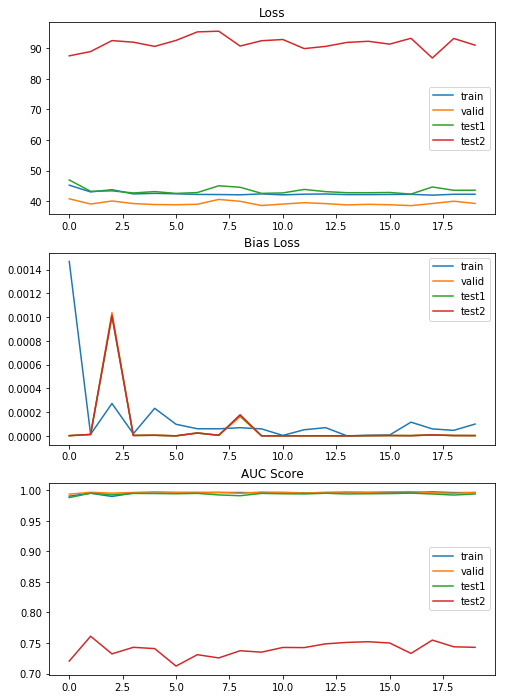

In [30]:
save = "adv5"

train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
test1_loss = [l['loss'] for l in history['test1']]
test2_loss = [l['loss'] for l in history['test2']]

train_bloss = [l['bias'] for l in history['train']]
valid_bloss = [l['bias'] for l in history['valid']]
test1_bloss = [l['bias'] for l in history['test1']]
test2_bloss = [l['bias'] for l in history['test2']]

train_auc = [l['auc'] for l in history['train']]
valid_auc = [l['auc'] for l in history['valid']]
test1_auc = [l['auc'] for l in history['test1']]
test2_auc = [l['auc'] for l in history['test2']]

plt.figure(figsize=(8,12))

plt.subplot(311)
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.plot(test1_loss, label='test1')
plt.plot(test2_loss, label='test2')
plt.legend()


plt.subplot(312)
plt.title('Bias Loss')
plt.plot(train_bloss, label='train')
plt.plot(valid_bloss, label='valid')
plt.plot(test1_bloss, label='test1')
plt.plot(test2_bloss, label='test2')
plt.legend()


plt.subplot(313)
plt.title('AUC Score')
plt.plot(train_auc, label='train')
plt.plot(valid_auc, label='valid')
plt.plot(test1_auc, label='test1')
plt.plot(test2_auc, label='test2')
plt.legend()
# if save:
#     path = os.path.join("output", save+'.png')
#     plt.savefig(path)
plt.show()